# kosarak

EOF
Execution time:  17.374 seconds.
100 nodes, per-node= <8 heavy+ 16 light>
Total size 112.265625 kbytes, 
Heavy part: 95.078125 kbytes
Light part: 17.1875 kbytes
Precision:  0.556
heavy_are:96.314,heavy_aae:9691.000
all_are: 446.176,all_aae: 463.658
Estimate time:   7.246 seconds.


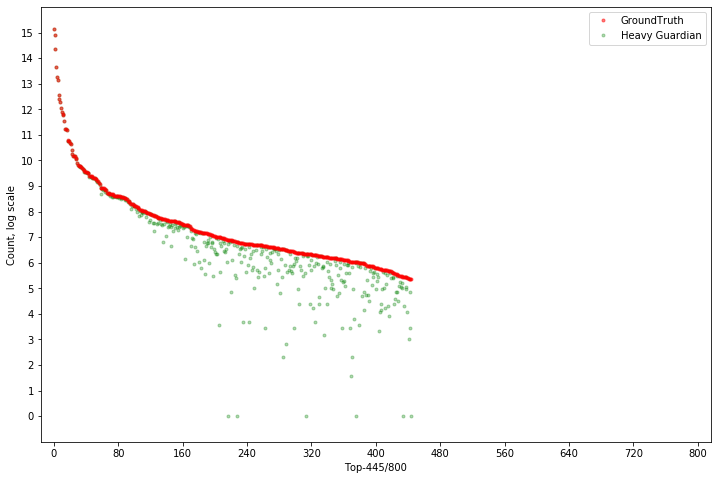

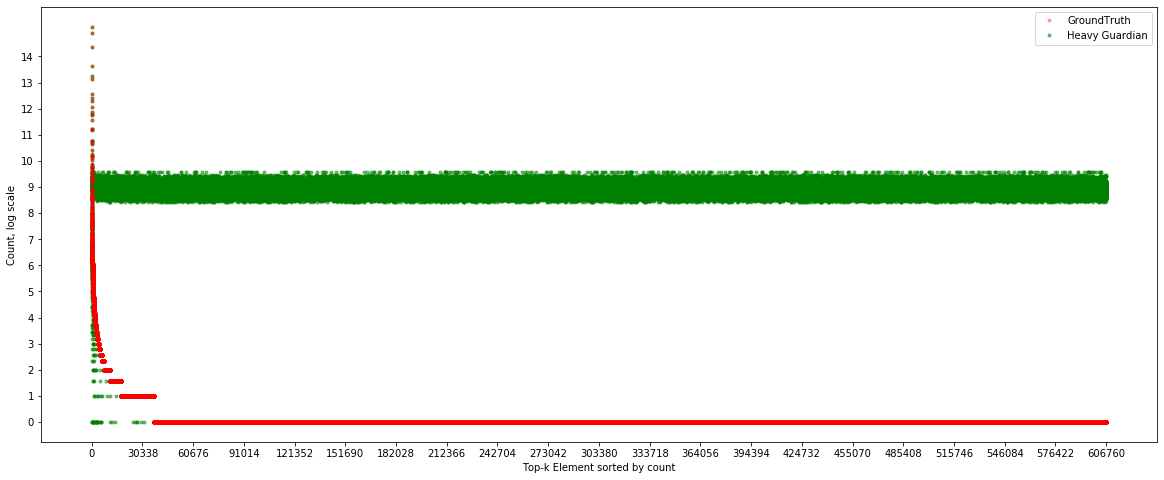

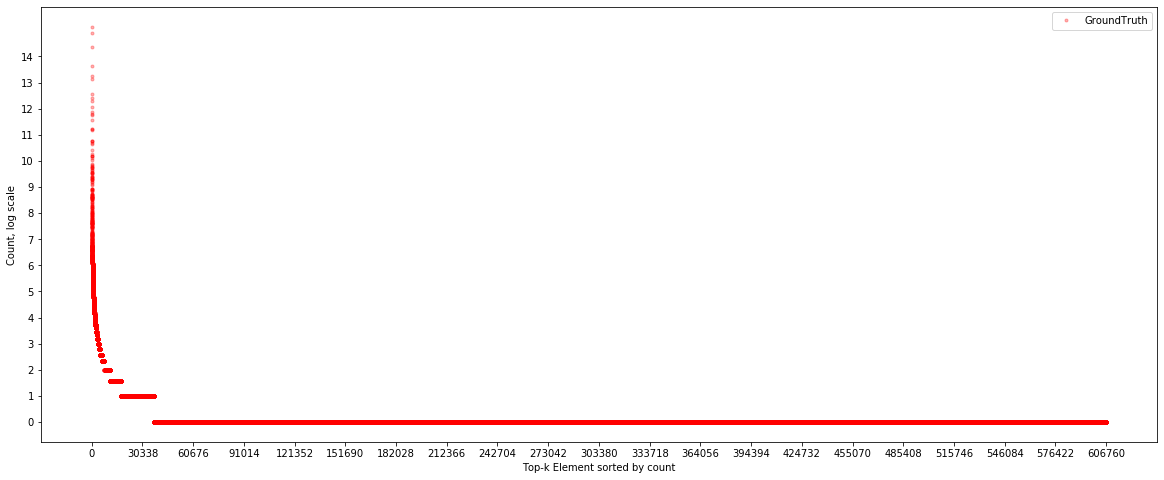

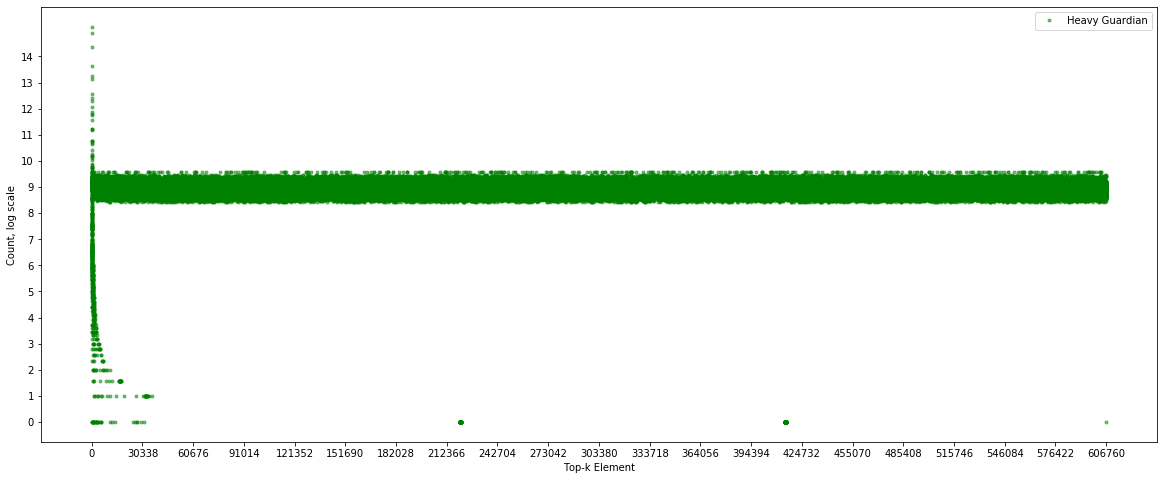

In [1]:
# 20220112 ok
import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time
import pandas as pd
import numpy as np

from pympler import asizeof

dataset='kosarak'

# =============================dataset path and file=============================

filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
heavy_size=8
light_size=16
size=100
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
# stream processing
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            # Heavy part insert
            #item_count-=1
            item=HG.Node(str(e),1)
            HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================Top-k from result=============================
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,topk)
print("Precision: {:6.3f}".format(precision))

# Count ARE/AAE
startx=time.time()
# heavy part
gr=pd.read_csv(gr_path)
gr=gr[:topk]
result=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
result=result[:topk]
diff=gr.merge(result,how='inner',on='Element',suffixes=('_t', '_r'))
hare,haae=Func.Get_HH_ARE_AAE(diff)

# all
heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,Top_dict)
endx=time.time()

print('heavy_are:{:6.3f},heavy_aae:{:6.3f}'.format(heavy_are,heavy_aae))
print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_topk_compare(gr_path,Top_dict,'Heavy Guardian')

# All element compare
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=Func.HG_Query(item,HG_list)
Func.Plot_all_compare(ground_truth,My_result,'Heavy Guardian')

# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\"+str(Config.size)+"_"+str(Config.heavy)

# Top_dict to csv
filename='HG_Top_'+str(Config.size*Config.heavy)+'_'+dataset+'.csv'
topdf=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

# Sketch to csv
import numpy as np

light=np.empty(Config.light,dtype='int32')
for item in HG_list:
    #print(item.light_part,item.light_part.shape)
    light=np.vstack([light,item.light_part])
light=light[1:]

filename='HG_Sketch_'+str(Config.size)+'x'+str(Config.light)+'_'+dataset+'.csv'
pd.DataFrame(light).to_csv((os.path.join(path,filename)),index=False)


## Caida for session

In [ ]:
# 20220112 ok
import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time
from pympler import asizeof
import pandas as pd
import numpy as np

# =============================for caida=============================
import re
dataset='caida'

# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='flows\caida_00_ground_truth.csv'
    # ground truth of srcip
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
heavy_size=8
light_size=16
size=100
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                # Heavy part insert
                #item_count-=1
                item=HG.Node(e,1)
                HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================Top-k from result=============================
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,topk)
print("Precision: {:6.3f}".format(precision))

# Count ARE/AAE
startx=time.time()
# heavy part
gr=pd.read_csv(gr_path)
gr=gr[:topk]
result=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
result=result[:topk]
diff=gr.merge(result,how='inner',on='Element',suffixes=('_t', '_r'))
hare,haae=Func.Get_HH_ARE_AAE(diff)

# all
heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,Top_dict)
endx=time.time()

print('heavy_are:{:6.3f},heavy_aae:{:6.3f}'.format(heavy_are,heavy_aae))
print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_topk_compare(gr_path,Top_dict,'Heavy Guardian')

# All element compare
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=Func.HG_Query(item,HG_list)
Func.Plot_all_compare(ground_truth,My_result,'Heavy Guardian')

# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\"+str(Config.size)+"_"+str(Config.heavy)

# Top_dict to csv
filename='HG_Top_'+str(Config.size*Config.heavy)+'_'+dataset+'.csv'
topdf=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

# Sketch to csv
import numpy as np

light=np.empty(Config.light,dtype='int32')
for item in HG_list:
    #print(item.light_part,item.light_part.shape)
    light=np.vstack([light,item.light_part])
light=light[1:]

filename='HG_Sketch_'+str(Config.size)+'x'+str(Config.light)+'_'+dataset+'.csv'
pd.DataFrame(light).to_csv((os.path.join(path,filename)),index=False)



# Caida for srcip

In [ ]:
# 20220112 ok
import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time

import re
from pympler import asizeof
dataset='caida'

# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_00_ground_truth.csv'
    # ground truth of srcip
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
heavy_size=8
light_size=16
size=100
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                # Heavy part insert
                #item_count-=1
                e=str(e[:4])
                # =================read src ip field only===================                
                item=HG.Node(e,1)
                HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================Top-k from result=============================
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,topk)
print("Precision: {:6.3f}".format(precision))

# Count ARE/AAE
startx=time.time()
# heavy part
gr=pd.read_csv(gr_path)
gr=gr[:topk]
result=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
result=result[:topk]
diff=gr.merge(result,how='inner',on='Element',suffixes=('_t', '_r'))
hare,haae=Func.Get_HH_ARE_AAE(diff)

# all
heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,Top_dict)
endx=time.time()

print('heavy_are:{:6.3f},heavy_aae:{:6.3f}'.format(heavy_are,heavy_aae))
print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_topk_compare(gr_path,Top_dict,'Heavy Guardian')

# All element compare
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=Func.HG_Query(item,HG_list)
Func.Plot_all_compare(ground_truth,My_result,'Heavy Guardian')

# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\"+str(Config.size)+"_"+str(Config.heavy)

# Top_dict to csv
filename='HG_Top_'+str(Config.size*Config.heavy)+'_'+dataset+'.csv'
topdf=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

# Sketch to csv
import numpy as np

light=np.empty(Config.light,dtype='int32')
for item in HG_list:
    #print(item.light_part,item.light_part.shape)
    light=np.vstack([light,item.light_part])
light=light[1:]

filename='HG_Sketch_'+str(Config.size)+'x'+str(Config.light)+'_'+dataset+'.csv'
pd.DataFrame(light).to_csv((os.path.join(path,filename)),index=False)



# webdocs

In [ ]:
# webdocs'
import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time
import pandas as pd
import numpy as np
import re

from pympler import asizeof
dataset='webdocs'

# =============================dataset path and file=============================
# dataset
filepath='..\..\dataset\webdocs'
pattern='out_.*'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='webdocs_00_ground_truth.csv'        
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
# set default value
heavy_size=8
light_size=16
size=100
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
# stream processing
#item_count=10000
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'r') as file:
        while True:
            e=file.readline().strip('\n')
            if not e:
                print("EOF")
                break
            else:     
                # Heavy part insert
                #item_count-=1
                item=HG.Node(str(e),1)
                HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================Top-k from result=============================
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,topk)
print("Precision: {:6.3f}".format(precision))

# Count ARE/AAE
startx=time.time()
# heavy part
gr=pd.read_csv(gr_path)
gr=gr[:topk]
gr['Element']=gr['Element'].astype('str')
result=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
result=result[:topk]
diff=gr.merge(result,how='inner',on='Element',suffixes=('_t', '_r'))
hare,haae=Func.Get_HH_ARE_AAE(diff)

# all
heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,Top_dict)
endx=time.time()

print('heavy_are:{:6.3f},heavy_aae:{:6.3f}'.format(heavy_are,heavy_aae))
print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_topk_compare(gr_path,Top_dict,'Heavy Guardian')

# All element compare
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=Func.HG_Query(item,HG_list)
Func.Plot_all_compare(ground_truth,My_result,'Heavy Guardian')

# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\"+str(Config.size)+"_"+str(Config.heavy)

# Top_dict to csv
filename='HG_Top_'+str(Config.size*Config.heavy)+'_'+dataset+'.csv'
topdf=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

# Sketch to csv
import numpy as np

light=np.empty(Config.light,dtype='int32')
for item in HG_list:
    #print(item.light_part,item.light_part.shape)
    light=np.vstack([light,item.light_part])
light=light[1:]

filename='HG_Sketch_'+str(Config.size)+'x'+str(Config.light)+'_'+dataset+'.csv'
pd.DataFrame(light).to_csv((os.path.join(path,filename)),index=False)
